<a href="https://colab.research.google.com/github/AldataSci/CapstoneData/blob/main/KMEanscluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering With KMeans

After cleaning up and merging the dataframes together with the complaints and riderships for 2019 and 2022 I will perform clustering.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
clean_cluster_2019 = pd.read_csv('https://raw.githubusercontent.com/AldataSci/CapstoneData/refs/heads/main/clean_cluster_2019.csv')
clean_cluster_2022 = pd.read_csv('https://raw.githubusercontent.com/AldataSci/CapstoneData/refs/heads/main/clean_cluster.csv')

# Looking at 2019 Cluster
I will analyze the 2019 year of crime/complaints at NYC Subway Station

In [6]:
clean_cluster_2019.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'cmplnt_fr_dt', 'cmplnt_fr_tm',
       'cmplnt_to_tm', 'rpt_dt', 'ofns_desc', 'crm_atpt_cptd_cd', 'law_cat_cd',
       'boro_nm', 'loc_of_occur_desc', 'prem_typ_desc', 'juris_desc',
       'jurisdiction_code', 'x_coord_cd', 'y_coord_cd', 'susp_age_group',
       'susp_race', 'susp_sex', 'transit_district', 'latitude', 'longitude',
       'lat_lon', 'station_name', 'day', 'month', 'year', 'complaint_count',
       'Matched_Station', 'Station (alphabetical by borough)', '2019'],
      dtype='object')

In [7]:
clean_cluster_2019_two = clean_cluster_2019[['Matched_Station','day','month','year','complaint_count','2019','latitude','longitude','boro_nm','ofns_desc','jurisdiction_code','law_cat_cd',
                                   'station_name']]

In [8]:
clean_cluster_2019_two.head(5)

,Matched_Station,day,month,year,complaint_count,2019,latitude,longitude,boro_nm,ofns_desc,jurisdiction_code,law_cat_cd,station_name
0,OZONE PARK LEFFERTS BLVD,1.0,1.0,2019.0,15,2216647.0,40.686234,-73.824175,QUEENS,GRAND LARCENY,1,FELONY,LEFFERTS BLVD.
1,59 ST COLUMBUS CIRCLE,1.0,1.0,2019.0,238,23040650.0,40.764818,-73.985189,MANHATTAN,DANGEROUS WEAPONS,1,FELONY,59 ST. COLUMBUS CIRCLE
2,BOWERY,1.0,1.0,2019.0,33,1325244.0,40.720321,-73.994040,MANHATTAN,CRIMINAL MISCHIEF & RELATED OF,1,FELONY,BOWERY
3,BEACH 25 ST,1.0,1.0,2019.0,9,517164.0,40.599872,-73.761560,QUEENS,GRAND LARCENY,1,FELONY,BEACH 25 ST
4,34 ST HERALD SQ,1.0,1.0,2019.0,151,39385436.0,40.749788,-73.987769,MANHATTAN,CRIMINAL MISCHIEF & RELATED OF,1,FELONY,34 ST. HERALD SQ.


In [9]:
# Calculate danger metrics per station
station_metrics2019 = clean_cluster_2019_two.groupby('station_name').agg({
    '2019': 'first',                     # ridership
    'complaint_count': 'first',            # total complaints
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()

# Calculate normalized danger metrics
station_metrics2019['crimes_per_million_riders'] = (station_metrics2019['complaint_count'] / station_metrics2019['2019']) * 1000000

In [10]:
station_metrics2019.sort_values(by = 'crimes_per_million_riders',ascending = False)

,station_name,2019,complaint_count,latitude,longitude,crimes_per_million_riders
127,ATLANTIC AV,469819.0,86,40.684052,-73.977458,183.049217
152,BROAD CHANNEL,90358.0,10,40.607932,-73.816044,110.670887
136,BEACH 36 ST,292305.0,11,40.602952,-73.749977,37.631926
294,ROCKAWAY AV,3238774.0,117,40.678278,-73.910755,36.124781
314,SUTTER AV,1047762.0,37,40.668272,-73.902625,35.313363
...,...,...,...,...,...,...
191,DISTRICT 33 OFFICE,8934900.0,5,40.677869,-73.903314,0.559603
71,36 AV,1933812.0,1,40.756580,-73.929752,0.517113
276,NORTHERN BLVD.,2008091.0,1,40.743125,-73.956068,0.497985
53,23 ST ELY AV,36265338.0,10,40.748108,-73.947355,0.275745


In [11]:
# Prepare features for clustering
features = [
    #'complaint_count',                   # absolute number of incidents
    'crimes_per_million_riders',         # normalized by ridership
    'latitude',                          # location for geographic patterns
    'longitude'
]

## KMeans Model Fitting

We now attempt to fit a KMeans Model

In [12]:
## Fit the KMeans Models Up
X = station_metrics2019[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

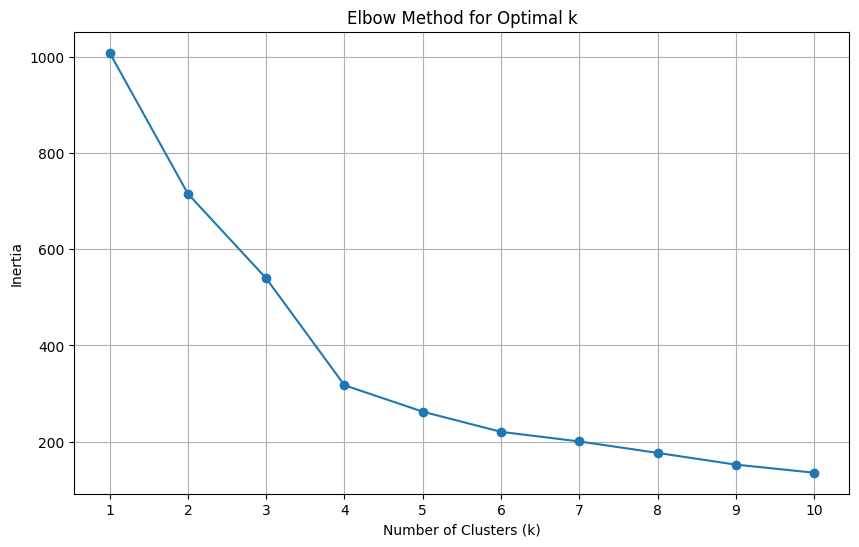

In [13]:
## Before we start, we are gonna perform parameter tuning for KMeans using The Elbow Method and The Silohutette Score
# Elbow Method
inertia = []
k_values = range(1, 11)  # Test k from 1 to 10
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

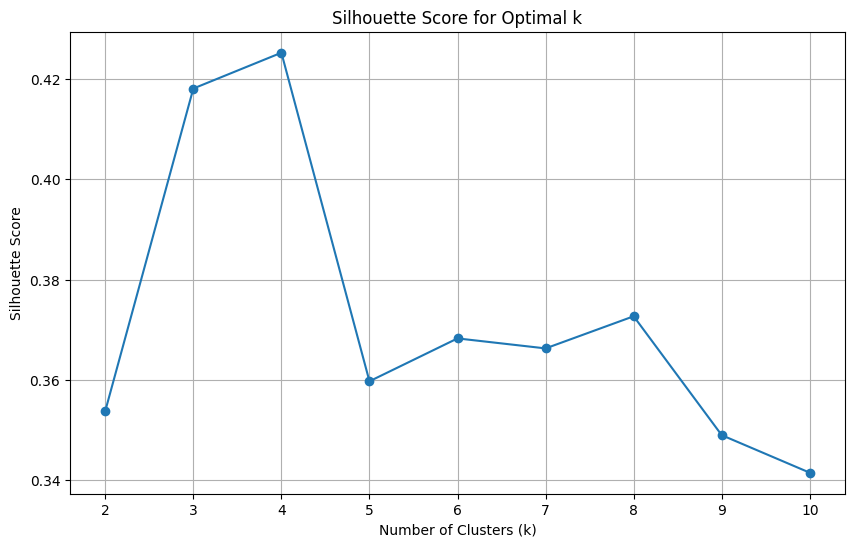

In [14]:
# Silhouette Score
silhouette_scores = []
for k in k_values[1:]:  # Start from 2 to avoid undefined silhouette score
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_values[1:], silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values[1:])
plt.grid()
plt.show()

We get different values for K according to the Silo Score and the Elbow Method but I will trust the Silo Score since we need to determine the optimal number of clusters. Hence the cluster number is 4

In [15]:
## It seems like the optimal clusters according to the SIlo Score and the Elbow Method is 4
kmeans = KMeans(n_clusters=4, random_state=42)  # 5 danger level categories
station_metrics2019['danger_cluster'] = kmeans.fit_predict(X_scaled)

WE check the average crimes to see which cluster is the most dangerous statistics

In [16]:
# Calculate average crimes per million riders per cluster
average_crimes_per_cluster = station_metrics2019.groupby('danger_cluster')['crimes_per_million_riders'].mean().reset_index()

# Rename the columns for clarity
average_crimes_per_cluster.columns = ['Cluster', 'Crime_per_million_rider']

# Display the result
print(average_crimes_per_cluster)

   Cluster  Crime_per_million_rider
0        0                 5.998315
1        1                10.474662
2        2                10.167545
3        3               146.860052


We see that cluster 3 contains the dangerous stations

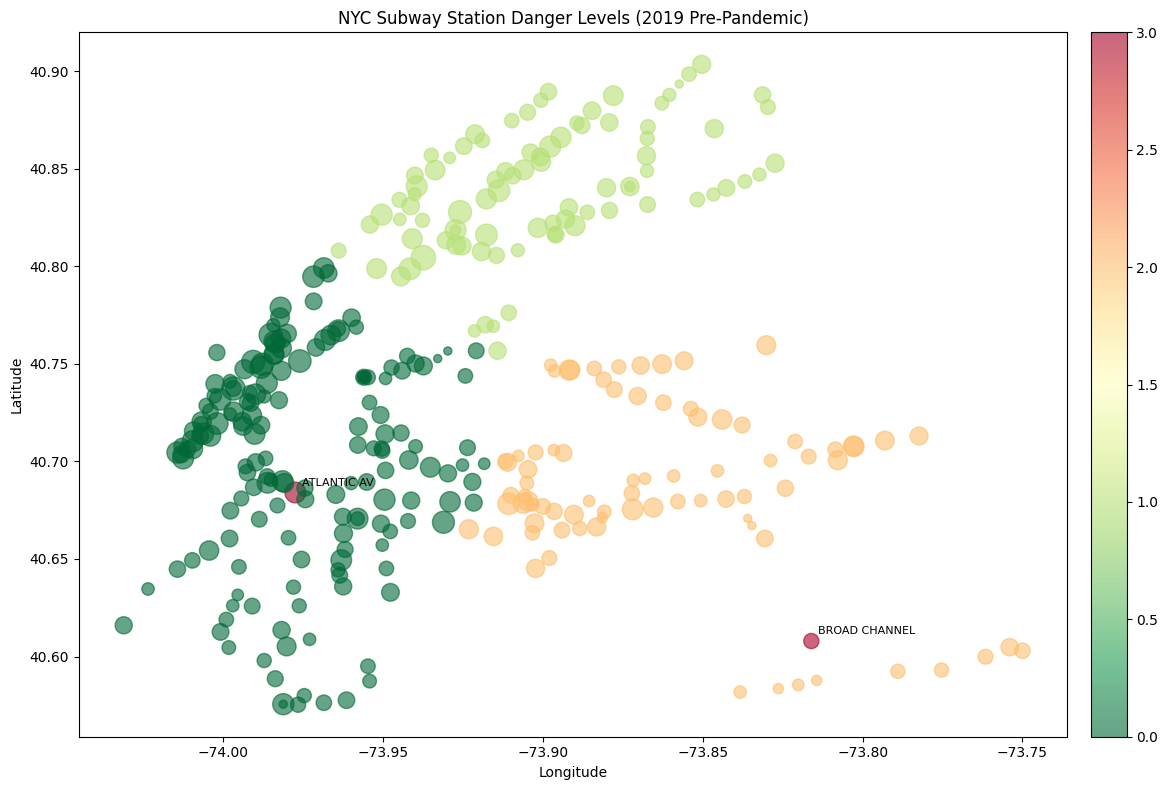

In [17]:
# Visualize dangerous stations on a map
plt.figure(figsize=(15, 8))

# Adjust the scaling factor for bubble sizes, we use log scale to make size differences more visible without extreme variations
sizes = np.log1p(station_metrics2019['complaint_count']) * 50

# We use the color scheme to intuitvely show danger levels..
scatter = plt.scatter(station_metrics2019['longitude'],
                     station_metrics2019['latitude'],
                     c=station_metrics2019['danger_cluster'],
                     s=sizes,
                     cmap='RdYlGn_r',
                     alpha=0.6)

# Create a more readable legend for bubble sizes
#legend_elements = [plt.scatter([], [], s=np.log1p(size)*50,
                         #    c='gray', alpha=0.6,
                          #   label=f'{size:,} Complaints')  # Add comma formatting
                 # for size in [10, 50, 100, 200]]

# Add color bar first we show the color bar to show danger level clusters
cbar = plt.colorbar(scatter,
                   pad=0.02)


plt.title('NYC Subway Station Danger Levels (2019 Pre-Pandemic)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add station names for the most dangerous cluster (Top 3 Clusters..)
most_dangerous = station_metrics2019[(station_metrics2019['danger_cluster'] == 3)]
for idx, row in most_dangerous.iterrows():
    plt.annotate(row['station_name'],
                (row['longitude'], row['latitude']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8)

# Adjust layout with more space on the right
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for both legends
plt.show()

Looking at the plot, we see that the subway stations are seperated into 3 different clusters, with the red representing the highest intensity and green represeneting the lowest intensity. The red stations are Altantic Ave and Broad Channel signifying that the highest incident_per rider occurs at these two stations.

# CLustering For 2022

Now we cluster for 2022..

In [18]:
clean_cluster_2022.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'cmplnt_fr_dt', 'cmplnt_fr_tm',
       'cmplnt_to_tm', 'rpt_dt', 'ofns_desc', 'crm_atpt_cptd_cd', 'law_cat_cd',
       'boro_nm', 'loc_of_occur_desc', 'prem_typ_desc', 'juris_desc',
       'jurisdiction_code', 'x_coord_cd', 'y_coord_cd', 'susp_age_group',
       'susp_race', 'susp_sex', 'transit_district', 'latitude', 'longitude',
       'lat_lon', 'station_name', 'day', 'month', 'year', 'complaint_count',
       'Matched_Station', 'Station (alphabetical by borough)', '2022'],
      dtype='object')

In [20]:
clean_cluster_2022_two = clean_cluster_2022[['Matched_Station','day','month','year','complaint_count','2022','latitude','longitude','ofns_desc','jurisdiction_code','law_cat_cd',
                                   'station_name']]

In [21]:
# Calculate danger metrics per station
station_metrics2022 = clean_cluster_2022_two.groupby('station_name').agg({
    '2022': 'first',                     # ridership
    'complaint_count': 'first',            # total complaints
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()

# Calculate normalized danger metrics
station_metrics2022['crimes_per_million_riders'] = (station_metrics2022['complaint_count'] / station_metrics2022['2022']) * 1000000

In [22]:
station_metrics2022.sort_values(by = 'crimes_per_million_riders',ascending = False)

,station_name,2022,complaint_count,latitude,longitude,crimes_per_million_riders
128,ATLANTIC AV,332637.0,106,40.684052,-73.977458,318.665693
153,BROAD CHANNEL,49631.0,14,40.607932,-73.816044,282.081763
315,SUTPHIN BLVD. ARCHER AVE.,836028.0,71,40.700582,-73.807742,84.925385
122,ALABAMA AV,365853.0,29,40.676801,-73.900024,79.266809
124,AQUEDUCT NORTH CONDUIT AVE.,142044.0,10,40.667116,-73.834650,70.400721
...,...,...,...,...,...,...
72,36 AV,1288740.0,1,40.756580,-73.929752,0.775952
54,23 ST ELY AV,19803472.0,10,40.748108,-73.947355,0.504962
1,102 ST,4758594.0,2,40.695158,-73.845395,0.420292
189,DISTRICT 1 OFFICE,5337253.0,2,40.764818,-73.985189,0.374725


In [23]:
# Prepare features for clustering
features = [
    #'complaint_count',                   # absolute number of incidents
    'crimes_per_million_riders',         # normalized by ridership
    'latitude',                          # location for geographic patterns
    'longitude'
]

In [24]:
## Fit the KMeans Models Up and we normalize our features..
X_2022 = station_metrics2022[features].copy()
scaler = StandardScaler()
X_scaled_2022 = scaler.fit_transform(X_2022)

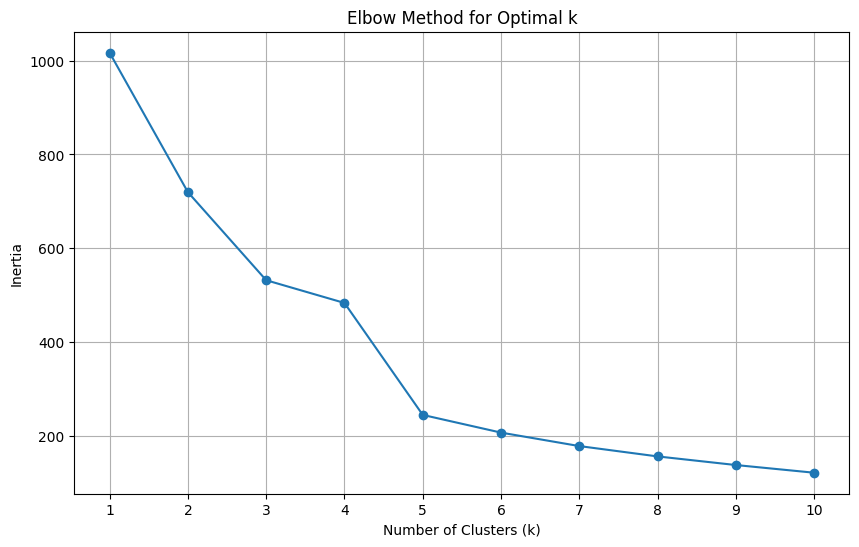

In [25]:
## Before we start, we are gonna perform parameter tuning for KMeans using The Elbow Method and The Silohutette Score
# Elbow Method
inertia = []
k_values = range(1, 11)  # Test k from 1 to 10
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled_2022)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

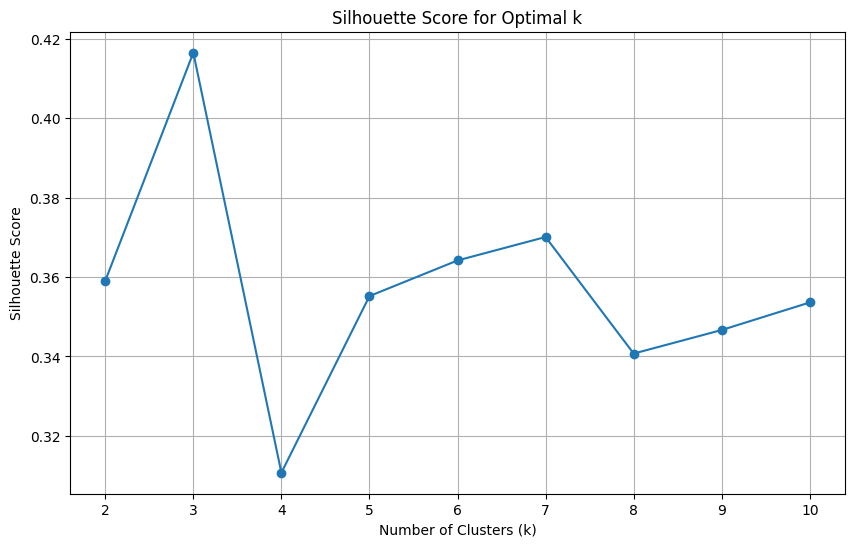

In [26]:
# Silhouette Score
silhouette_scores = []
for k in k_values[1:]:  # Start from 2 to avoid undefined silhouette score
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled_2022)
    score = silhouette_score(X_scaled_2022, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_values[1:], silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values[1:])
plt.grid()
plt.show()

In [27]:
## It seems like the optimal clusters according to the SIlo Score and the Elbow Method is 3
kmeans = KMeans(n_clusters=3, random_state=42)  # 5 danger level categories
station_metrics2022['danger_cluster'] = kmeans.fit_predict(X_scaled_2022)

The danger_cluster groups subway stations based on their crime data. The cluster number is just a label and does not indicate how dangerous a station is. To determine danger levels, we look at the average number of complaints in each cluster. For instance, if cluster 4 has a high average of complaints, then stations in that cluster are considered more dangerous.

In [28]:
# Calculate average crimes per million riders per cluster
average_crimes_per_cluster = station_metrics2022.groupby('danger_cluster')['crimes_per_million_riders'].mean().reset_index()

# Rename the columns for clarity
average_crimes_per_cluster.columns = ['Cluster', 'Crime_per_million_rider']

# Display the result
print(average_crimes_per_cluster)

   Cluster  Crime_per_million_rider
0        0                 9.097331
1        1                15.355106
2        2                34.885330


For the 2022 dataset, we have three different clusters and cluster 2 contains the highest crime_per_million rider

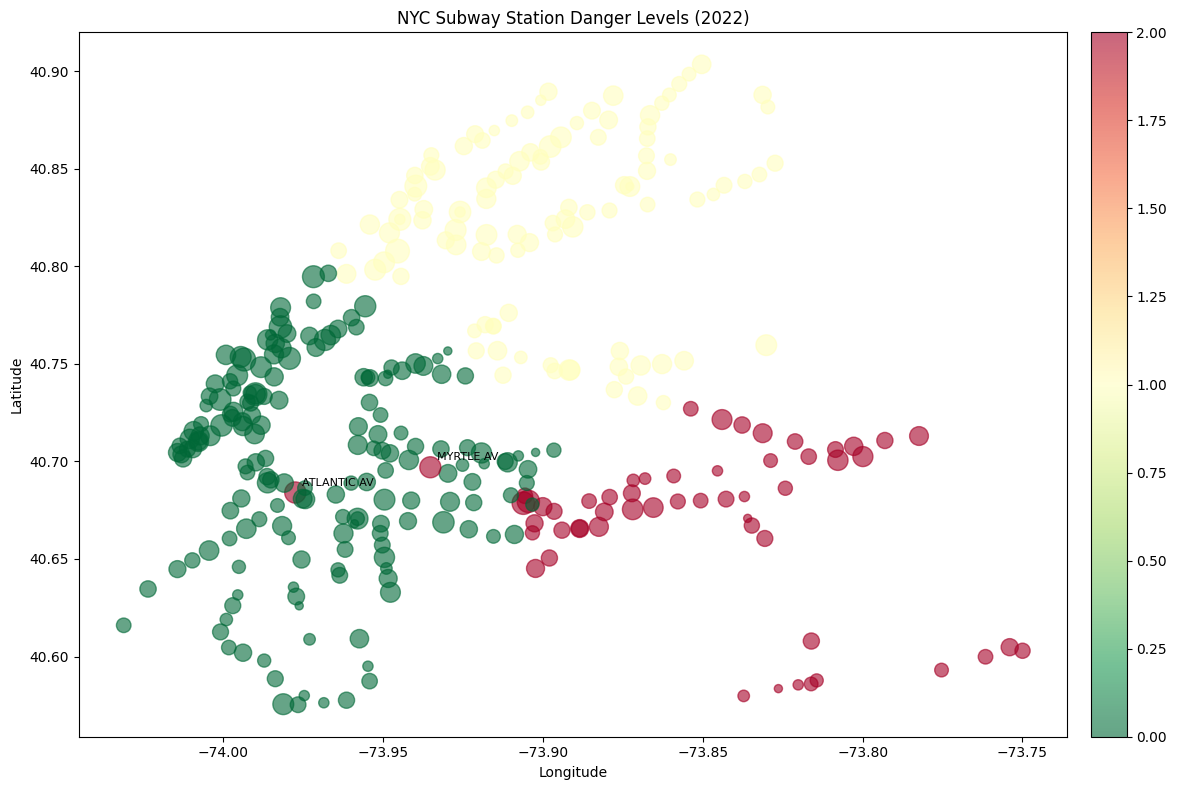

In [29]:
# Visualize dangerous stations on a map
plt.figure(figsize=(15, 8))

# Adjust the scaling factor for bubble sizes, we use log scale to make size differences more visible without extreme variations
sizes = np.log1p(station_metrics2022['complaint_count']) * 50

# We use the color scheme to intuitvely show danger levels..
scatter = plt.scatter(station_metrics2022['longitude'],
                     station_metrics2022['latitude'],
                     c=station_metrics2022['danger_cluster'],
                     s=sizes,
                     cmap='RdYlGn_r',
                     alpha=0.6)




# Create a more readable legend for bubble sizes
#legend_elements = [plt.scatter([], [], s=np.log1p(size)*50,
                        #     c='gray', alpha=0.6,
                          #   label=f'{size:,} Complaints')  # Add comma formatting
                 # for size in [10, 50, 100, 200]]

# Add color bar first we show the color bar to show danger level clusters
cbar = plt.colorbar(scatter,
                   pad=0.02)

plt.title('NYC Subway Station Danger Levels (2022)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add station names for the most dangerous cluster (Top 3 Clusters..) The top 2 dangerous are 125 ST and Altantic Ave (according to Cluster..)
most_dangerous = station_metrics2022[(station_metrics2022['danger_cluster'] == 2)]
for idx,row in most_dangerous.iterrows():
    if row['station_name'] in ['ATLANTIC AV', 'MYRTLE AV']:
        # Adjust the offset based on the index to space out the labels
        plt.annotate(row['station_name'],
                     (row['longitude'], row['latitude']),
                     xytext=(5,5), textcoords='offset points',
                     fontsize=8)

# Adjust layout with more space on the right
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for both legends
plt.show()

Here the Red dots, signify dangerous stations and the highest intensity stations are located within Brooklyn and Lower Queens. I also highlighted stations like Myrtle Ave and Atlantic Ave since they are colored red within the green zone i.e stations with the lowest incident count